In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# allow for imports from parent folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.dataset import make_dataset
from src.preprocessing import build_features
from src.preprocessing import data_cleaning
from src.preprocessing import preprocessing
from src.models import train_model
from src.visualizations import visualize

In [ ]:
# set random state
rand_state = 1

# Load files into memory

In [ ]:
counts_filename = 'data/count_data_species_raw_WIS_overlapping_fungi_bacteria_12773samples.tsv'
metadata_filename = 'data/metadata_species_WIS_overlapping_fungi_bacteria_12773samples.tsv'

In [ ]:
counts = md.read_fungi_data(counts_filename)
metadata = md.read_fungi_data(metadata_filename)

metadata = metadata.replace('Not available', np.nan)

#TODO Merge this later?
#combined = pd.merge(metadata, counts, on="sampleid", how="inner")

print('Metadata Shape:\t' + str(metadata.shape))
print('Counts Shape:\t' + str(counts.shape))
#print('Combined Shape:\t' + str(combined.shape))

In [ ]:
# # note 76% of samples dont have DTD
# print("Days to Death - NA: " + str(round(combined["days_to_death"].isna().mean(), 3) * 100) + '%')

# # 3036 data points to work with
# print("Rows remaining: " + str(combined["days_to_death"].notna().sum()))

# plt.boxplot(combined['days_to_death'], vert=False)
# plt.show()

In [ ]:
metadata["pathologic_stage_label"]

In [ ]:
combined = pd.merge(metadata, counts, on="sampleid", how="inner")

combined = dc.filter_metadata(combined)

combined['pathologic_t_label'] = dc.reduce_stages(combined['pathologic_t_label'])
combined['pathologic_n_label'] = dc.reduce_stages(combined['pathologic_n_label'])
combined['pathologic_stage_label'] = dc.reduce_stages(combined['pathologic_stage_label'])

combined.shape

## Metadata Regression

In [ ]:
# TODO Create OrdinalEncoder for ordinal features in preprocessing.py

In [ ]:
pp.preprocess_metadata(metadata).head()

## Regression Model

In [ ]:
reg_data = combined[combined["days_to_death"].notna()]

In [ ]:
reg_data.shape

In [ ]:
# separate X and Y and generate 

test_prop = 0.1
reg_X = reg_data.drop(columns=metadata.columns)
reg_Y = reg_data["days_to_death"]
reg_Xtrain, reg_Xtest, reg_Ytrain, reg_Ytest = train_test_split(reg_X, reg_Y, test_size=test_prop, random_state=rand_state)

In [ ]:
reg_model = LinearRegression()
reg_model.fit(reg_Xtrain, reg_Ytrain)
preds = reg_model.predict(reg_Xtest)
preds = [x if x > 0 else 0 for x in preds] # Replace negative predictions
scores = mean_squared_error(reg_Ytest, preds)
scores

In [ ]:
(reg_Ytest - preds).head()

## run.py test

In [3]:
args = ["cs"]

In [4]:
if "test" in args:
    metadata_filename = "data/test/test_metadata.tsv"
    counts_filename = "data/test/test_fungi.tsv"
else:
    counts_filename = 'data/count_data_species_raw_WIS_overlapping_fungi_bacteria_12773samples.tsv'
    metadata_filename = 'data/metadata_species_WIS_overlapping_fungi_bacteria_12773samples.tsv'

counts_filename = os.path.join(os.pardir, counts_filename)    
metadata_filename = os.path.join(os.pardir, metadata_filename)   

# load fungi counts and metadata into
counts = make_dataset.read_fungi_data(counts_filename)
raw_metadata = make_dataset.read_fungi_data(metadata_filename)
metadata = raw_metadata.replace('Not available', np.nan)
metadata.shape

(12773, 41)

In [5]:
cancer_stage = "pathologic_stage_label"
# clean cancer stage column s.t. only stages I, II, III, and IV remain
metadata[cancer_stage] = data_cleaning.reduce_stages(metadata[cancer_stage])
metadata = metadata[metadata.pathologic_stage_label.isin(["Stage I", "Stage II", "Stage III", "Stage IV"])]
counts = counts.loc[metadata.index]

Y = build_features.OHE_col(metadata[cancer_stage])
metadata.shape

(8643, 41)

In [6]:
X = metadata.drop(cancer_stage, axis=1)
X = preprocessing.preprocess_metadata(X)
X = pd.merge(X, counts, on="sampleid", how="inner")
X.shape

(8643, 465)

In [9]:
model, auroc_plt_data, aupr_plt_data = train_model.train_classify_cancer_stages(X, Y)

Starting Cancer Stage: Stage I
Starting Cancer Stage: Stage II
Starting Cancer Stage: Stage III
Starting Cancer Stage: Stage IV


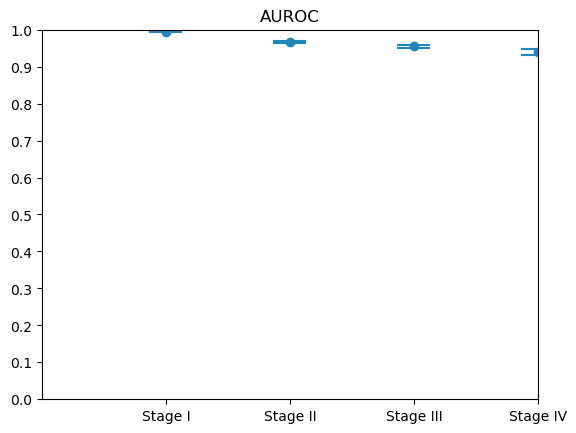

In [10]:
visualize.init_visualization(Y)
i = 1
for stage in auroc_plt_data.keys():
    visualize.plot_confidence_interval(i, auroc_plt_data[stage])
    i += 1

In [ ]:
%run run.py test cs

In [ ]:
%run run.py test dtd